# SHAP for 4-Week Model

Gaylen Fronk  
January 15, 2025

In [ ]:
study <- "match"
version <- "v6"
y_col_name <- "pp_hybrid_wk4_outcome"


In [ ]:

# packages for script
library(tidyverse)


── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

In [ ]:

# handle conflicts
options(conflicts.policy = "depends.ok")


In [ ]:
# absolute paths
switch (Sys.info()[['sysname']],
        # PC paths
        Windows = {
          path_data <- str_c("P:/chtc/", y_col_name)},
        
        # IOS paths
        Darwin = {
          path_data <- str_c("/Volumes/chtc/", y_col_name)},
        
        # Linux paths
        Linux = {
          path_data <- str_c("~/mnt/chtc/", y_col_name)}
)


In [ ]:
# chunk defaults

options(tibble.width = Inf)
options(tibble.print_max = Inf)


## Read in data

SHAP obtained with LOOCV at CHTC

In [ ]:
local <- read_csv(file.path(path_data, str_c("shap_loocv_", version), 
                            "output", "batch_results.csv"),
                  col_types = "cddd") |> 
  mutate(tx_int = if_else(str_detect(variable_name, "treatment_"), "Interactions", "Main Effects"))

glimpse(local)


Rows: 1,272,852
Columns: 5
$ variable_name  <chr> "age_1st_cig", "age_daily_smoker", "age_ehr", "alc_bing…
$ variable_value <dbl> 0.18140, -0.56780, 0.57420, 0.70530, 1.41800, -0.02156,…
$ contribution   <dbl> 0.0000000000, 0.0000000000, 0.0000000000, 0.0000000000,…
$ subid          <dbl> 51514, 51514, 51514, 51514, 51514, 51514, 51514, 51514,…
$ tx_int         <chr> "Main Effects", "Main Effects", "Main Effects", "Main E…

This dataset is already local SHAP values because we have one observation per subid per variable.

## Get global Shapley values

In [ ]:
global <- local |> 
  mutate(abs_contribution = abs(contribution)) |> 
  group_by(variable_name) |> 
  summarize(mean_contribution = mean(abs_contribution)) |> 
  mutate(tx_int = if_else(str_detect(variable_name, "treatment_"), "Interactions", "Main Effects"))|> 
  arrange(desc(mean_contribution))

glimpse(global)


Rows: 1,173
Columns: 3
$ variable_name     <chr> "co", "race_ehr_white", "wisdm37_2_item_order", "mot…
$ mean_contribution <dbl> 0.029854168, 0.023656426, 0.018174897, 0.016328284, …
$ tx_int            <chr> "Main Effects", "Main Effects", "Main Effects", "Mai…

Add interpretable names

In [ ]:
global_tx <- global |> 
  filter(tx_int == "Interactions") |> 
  arrange(desc(mean_contribution)) |> 
  slice(1:25) |> 
  arrange(mean_contribution) |> 
  mutate(Feature = c(
    "C-NRT X Divorced",
    "C-NRT X Currently smokes menthol cigarettes",
    "Patch X Bothered by craving a cigarette (WSWS-2)",
    "Varenicline X Kept smoking despite relationship problems (DSM-5)",
    "C-NRT X Married",
    "Varenicline X Does not live with another smoker",
    "Varenicline X Has never tried cigars",
    "C-NRT X Worries they're going crazy if they can't keep their mind on a task (ASI-3)",
    "C-NRT X Does not endorse withdrawal symptoms (DSM-5)",
    "Patch X Has never tried cigars",
    "C-NRT X Identifies as White",
    "C-NRT X Most of their friends and acquaintances smoke (WISDM-37)",
    "Varenicline X No close relative who smokes",
    "Patch X Has tried cigars but has never used regularly",
    "Varenicline X Does not think they do a lot in a day (MFI)",
    "Patch X No close friend who smokes",
    "Varenicline X Has a spouse/partner who does not smoke",
    "Varenicline X Greater income",
    "Varenicline X Worries they'll choke to death when their throat feels tight (ASI-3)",
    "C-NRT X Identifies as Black or African American",
    "C-NRT X Has never smoked menthol cigarettes",
    "Varenicline X Lives alone or only with a partner",
    "C-NRT X Disagrees that there's nothing worse than feeling distressed/upset (DTS)",
    "C-NRT X Sometimes feels like cigarattes are their best friends (WISDM-37)",
    "C-NRT X Lives alone or only with a partner"
  )) |> 
  mutate(Feature = fct_inorder(Feature))

global_fig <- global |> 
  arrange(desc(mean_contribution)) |> 
  slice(1:25) |> 
  arrange(mean_contribution) |> 
  mutate(Feature = c(
    "C-NRT X Identifies as Black or African American",
    "A lot of friends or family members smoke (WISDM-37)",
    "C-NRT X Has never smoked menthol cigarettes",
    "Varenicline X Lives alone or only with a partner",
    "C-NRT X Disagrees that there's nothing worse than feeling distressed/upset (DTS)",
    "Does not dread having to do things (MFI Item 9)",
    "Endorses that the flavor of a cigarette is pleasing (WISDM-37)",
    "More satisfied with their life as a whole",
    "Currently smokes menthol cigarettes",
    "Does not have a lot of plans (MFI)",
    "C-NRT X Sometimes feels like cigarattes are their best friends (WISDM-37)",
    "Greater income",
    "More time around smokers on the weekend",
    "Won't do much to stop feeling distessed or upset (DTS)",
    "Identifies as Black or African American",
    "Enjoys being with their family or close friends (SHP)",
    "Worries they will choke to death when their throat feels tight (ASI-3)",
    "C-NRT X Lives alone or only with a partner",
    "Bothered by wanting to smoke (WSWS-2)",
    "Greater duration of longest previous quit attempt",
    "Most of their friends and acquaintances smoke (WISDM-37)",
    "Greater motivation to quit",
    "Endorses feeling cigarettes control them (WISDM-37)",
    "Identifies as White",
    "Greater exhaled carbon monoxide"
  )) |> 
  mutate(Feature = fct_inorder(Feature))


## Make global figures

Overall

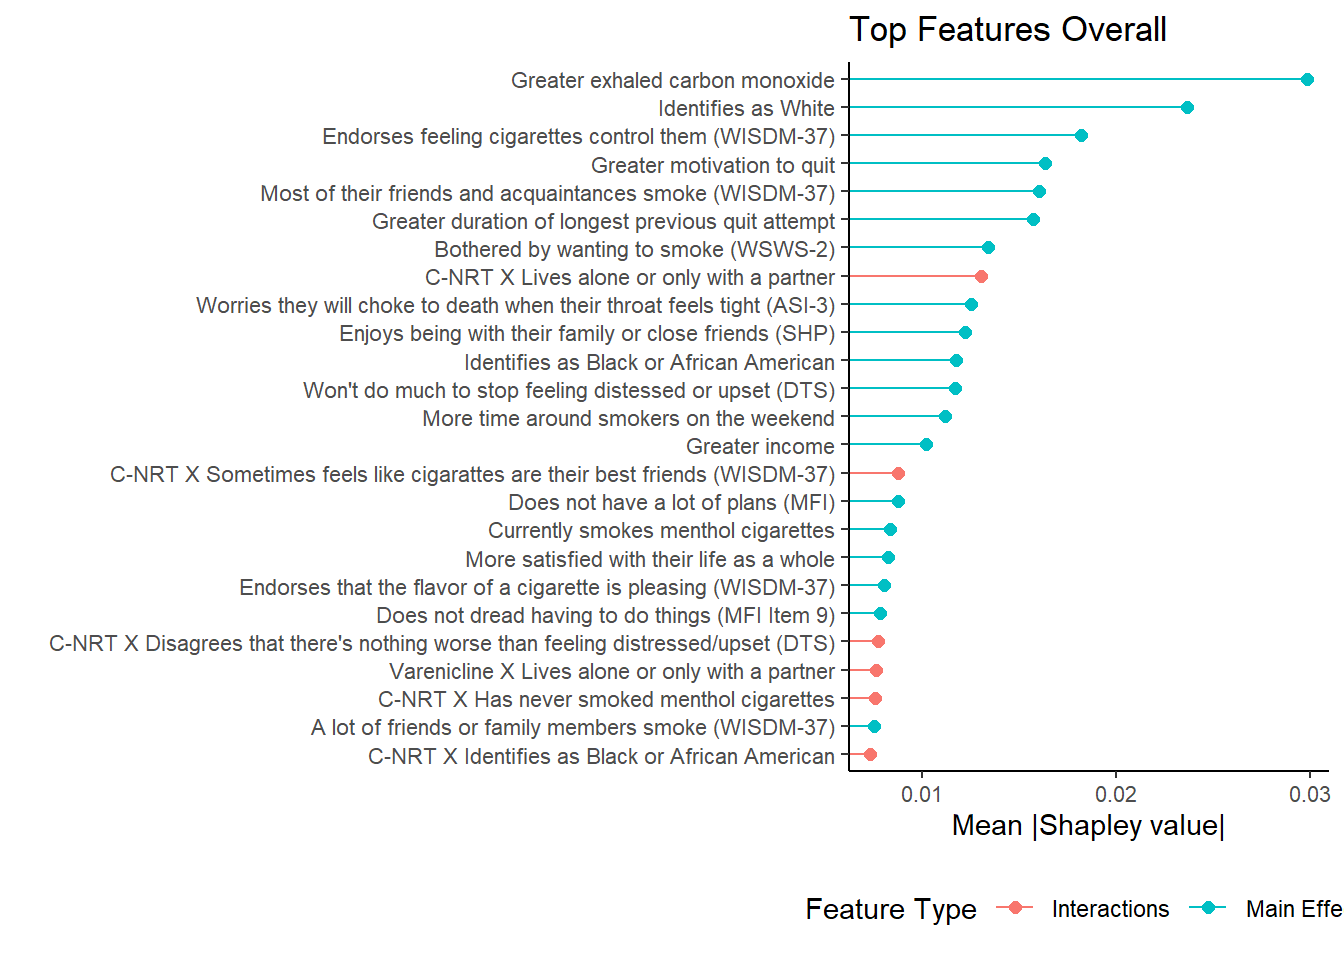

In [ ]:
fig_shap_global <- global_fig |> 
  ggplot(mapping = aes(x = Feature, y = mean_contribution, color = tx_int)) +
  geom_point(size = 2) +
  geom_segment(aes(x = Feature, y = mean_contribution, xend = Feature),
               yend = 0) +
  labs(
    x = "",
    y = "Mean |Shapley value|",
    color = "Feature Type",
    title = "Top Features Overall"
  ) +
  scale_y_continuous(breaks = c(0.01, 0.02, 0.03)) +
  coord_flip() +
  theme(legend.position = "bottom",
        axis.text = element_text(size = rel(0.75)),
        axis.title = element_text(size = rel(1)))

fig_shap_global


Global Shapley values among treatment interactions

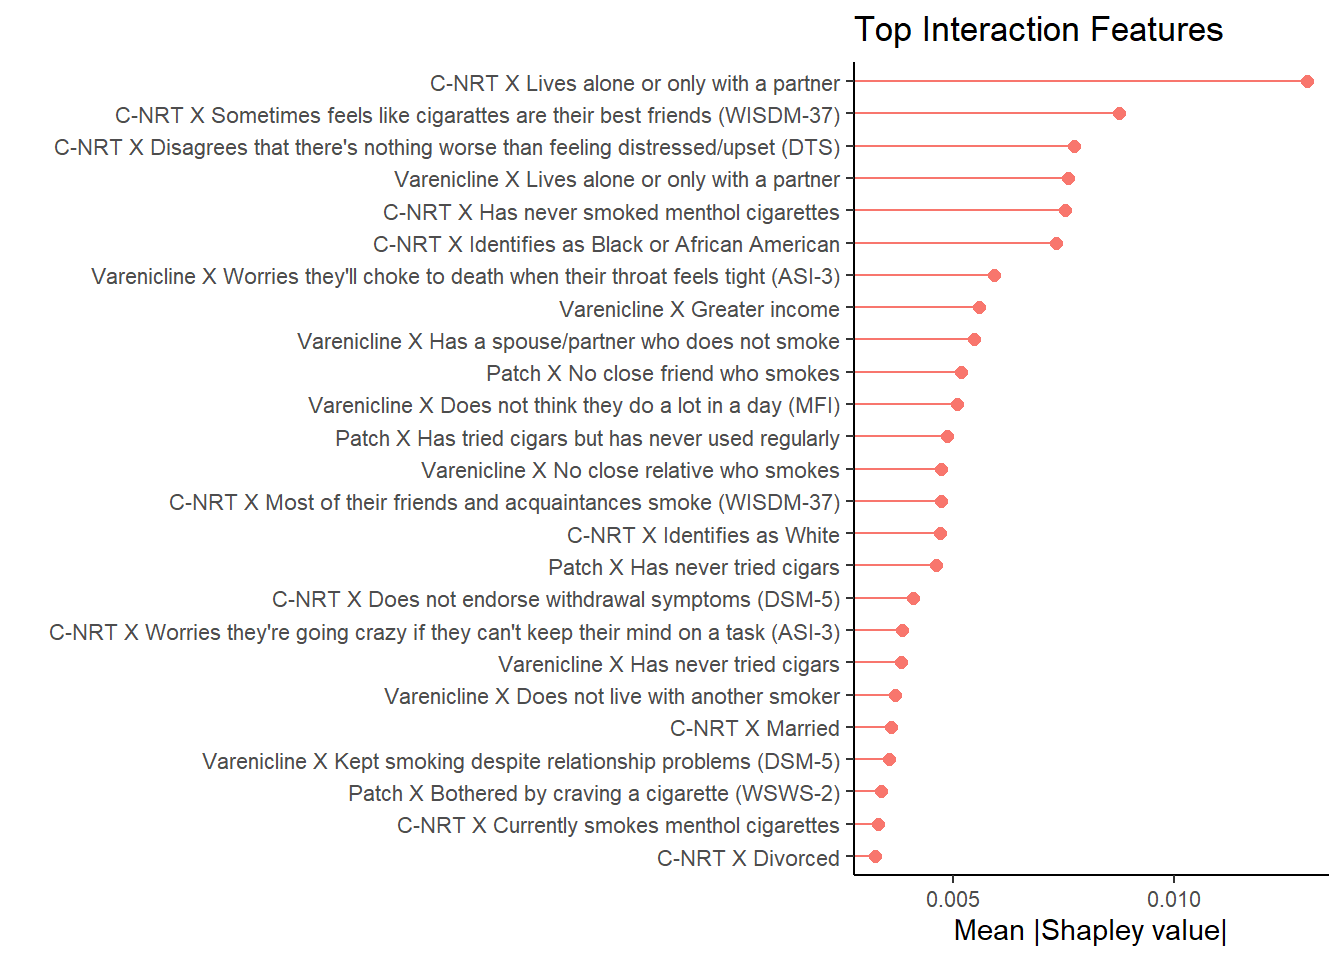

In [ ]:
fig_shap_global_tx <- global_tx |> 
  ggplot(mapping = aes(x = Feature, y = mean_contribution, color = tx_int)) +
  geom_point(size = 2) +
  geom_segment(aes(x = Feature, y = mean_contribution, xend = Feature),
               yend = 0) +
  labs(
    x = "",
    y = "Mean |Shapley value|",
    title = "Top Interaction Features"
  ) +
  scale_y_continuous(breaks = c(0.005, 0.01)) +
  coord_flip() +
  theme(legend.position = "none",
        axis.text = element_text(size = rel(0.75)),
        axis.title = element_text(size = rel(1)))

fig_shap_global_tx


Paneled Global figure

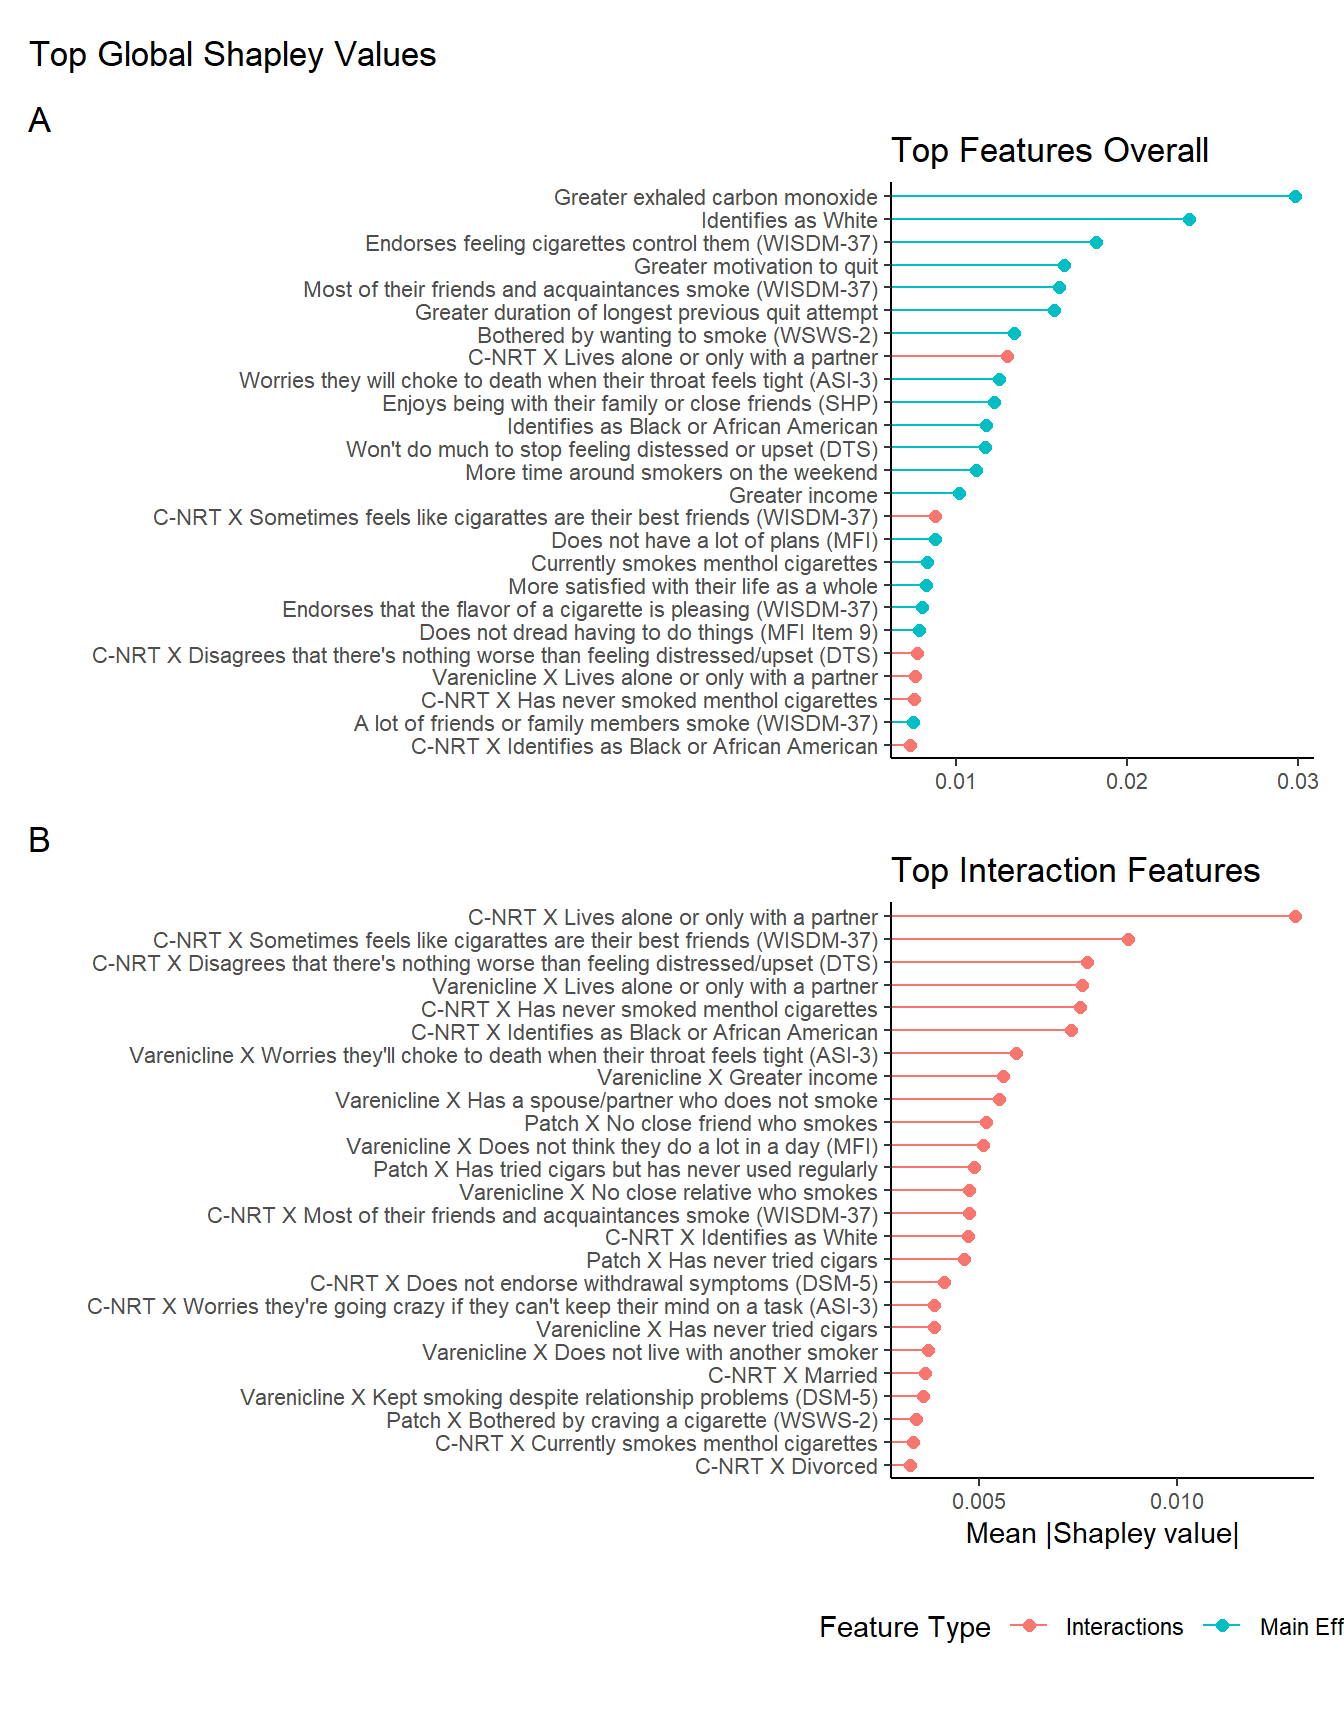

In [ ]:

fig_panel_shap_global <- (fig_shap_global / fig_shap_global_tx / guide_area()) +
  plot_layout(guides = "collect", axes = "collect", ncol = 1,
              heights = unit(c(3, 3, 0.5), "in")) +
  plot_annotation(tag_levels = "A",
                  title = "Top Global Shapley Values")

fig_panel_shap_global


“Panel A” only (overall global SHAP)

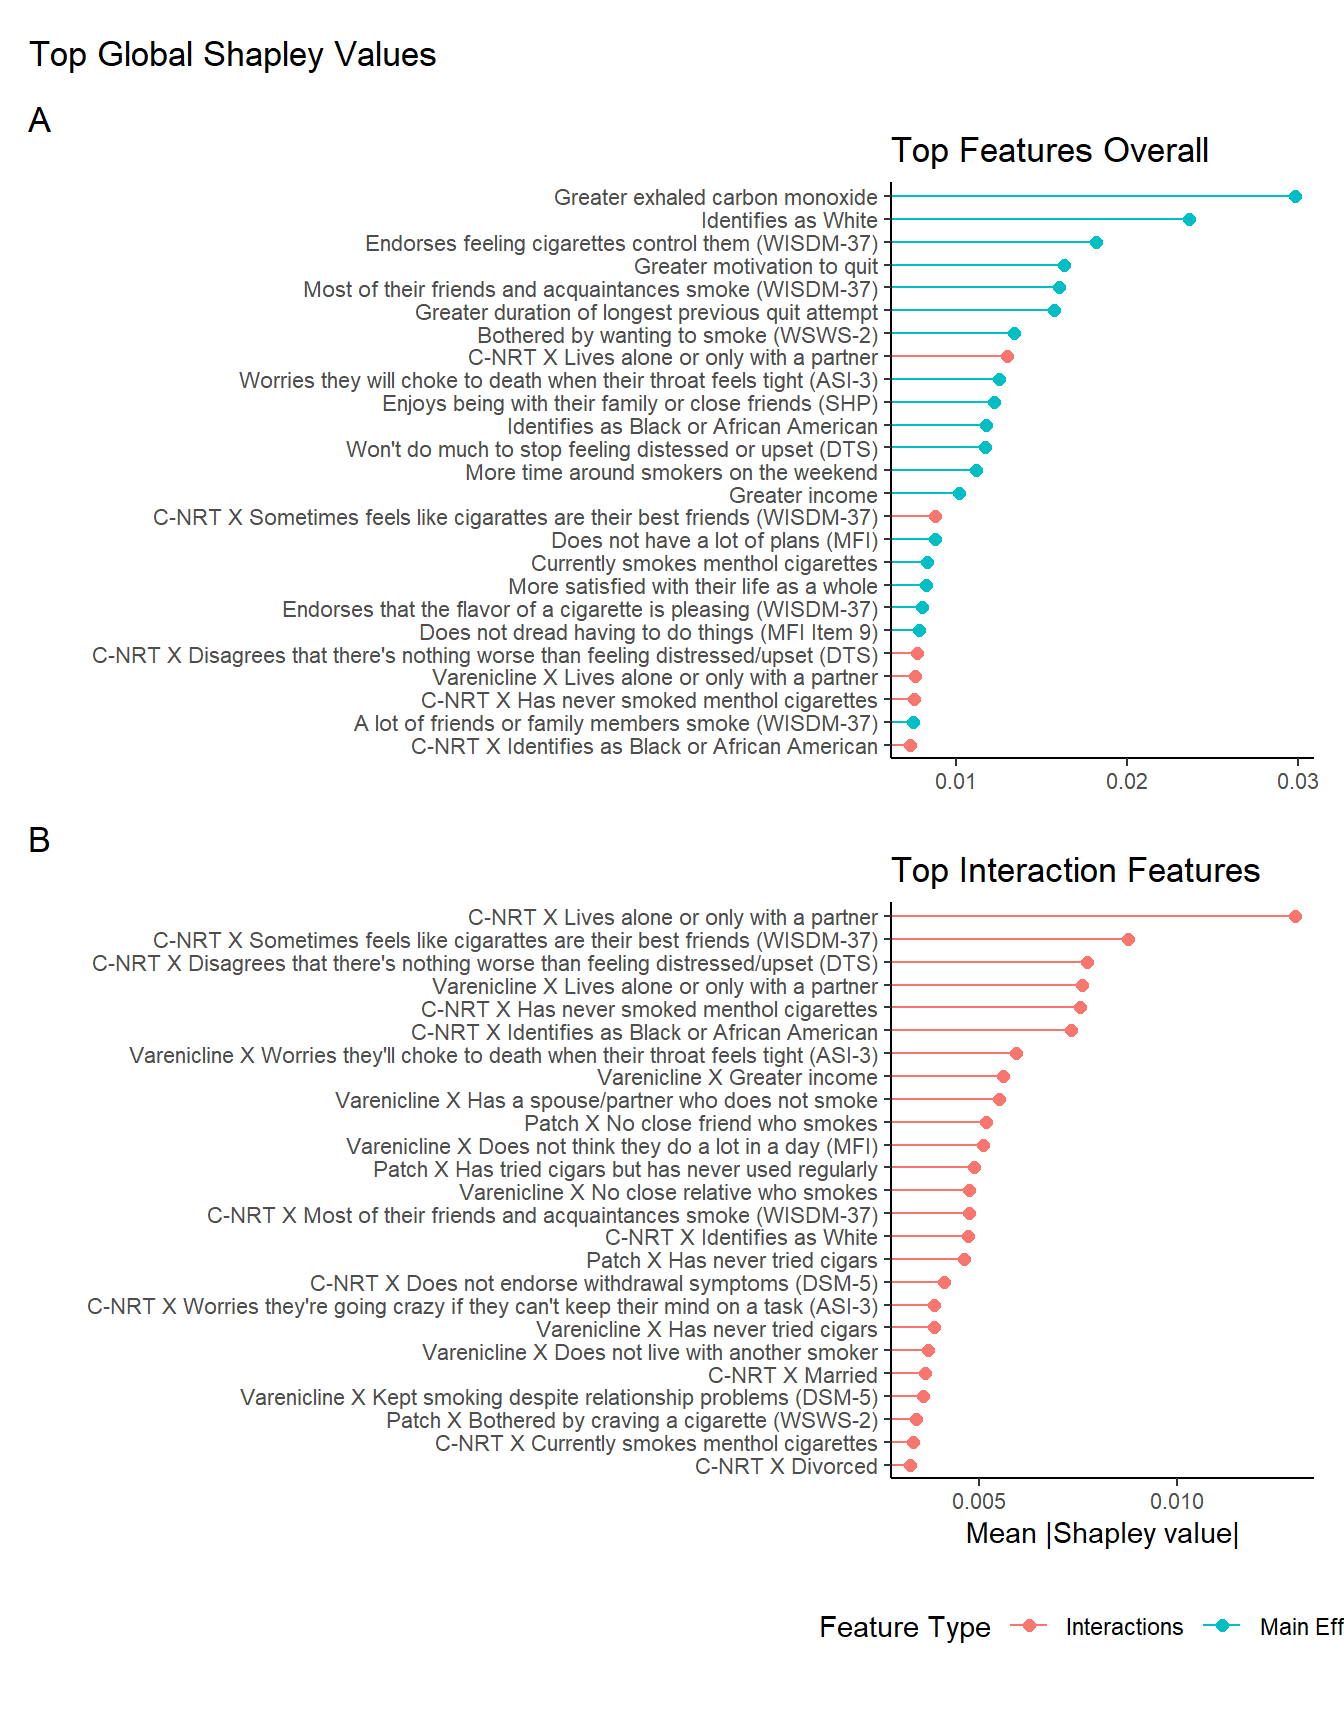

In [ ]:

fig_panel_shap_global


## Make grouped figure

Get grouped Shapley values

In [ ]:
global_grouped <- local |> 
  group_by(subid, tx_int) |> 
  summarize(group_contribution = sum(contribution), .groups = "drop") |> 
  group_by(tx_int) |> 
  summarize(group_mean_contribution = mean(abs(group_contribution)), .groups = "drop")

glimpse(global_grouped)


Rows: 2
Columns: 2
$ tx_int                  <chr> "Interactions", "Main Effects"
$ group_mean_contribution <dbl> 0.04013667, 0.10696700

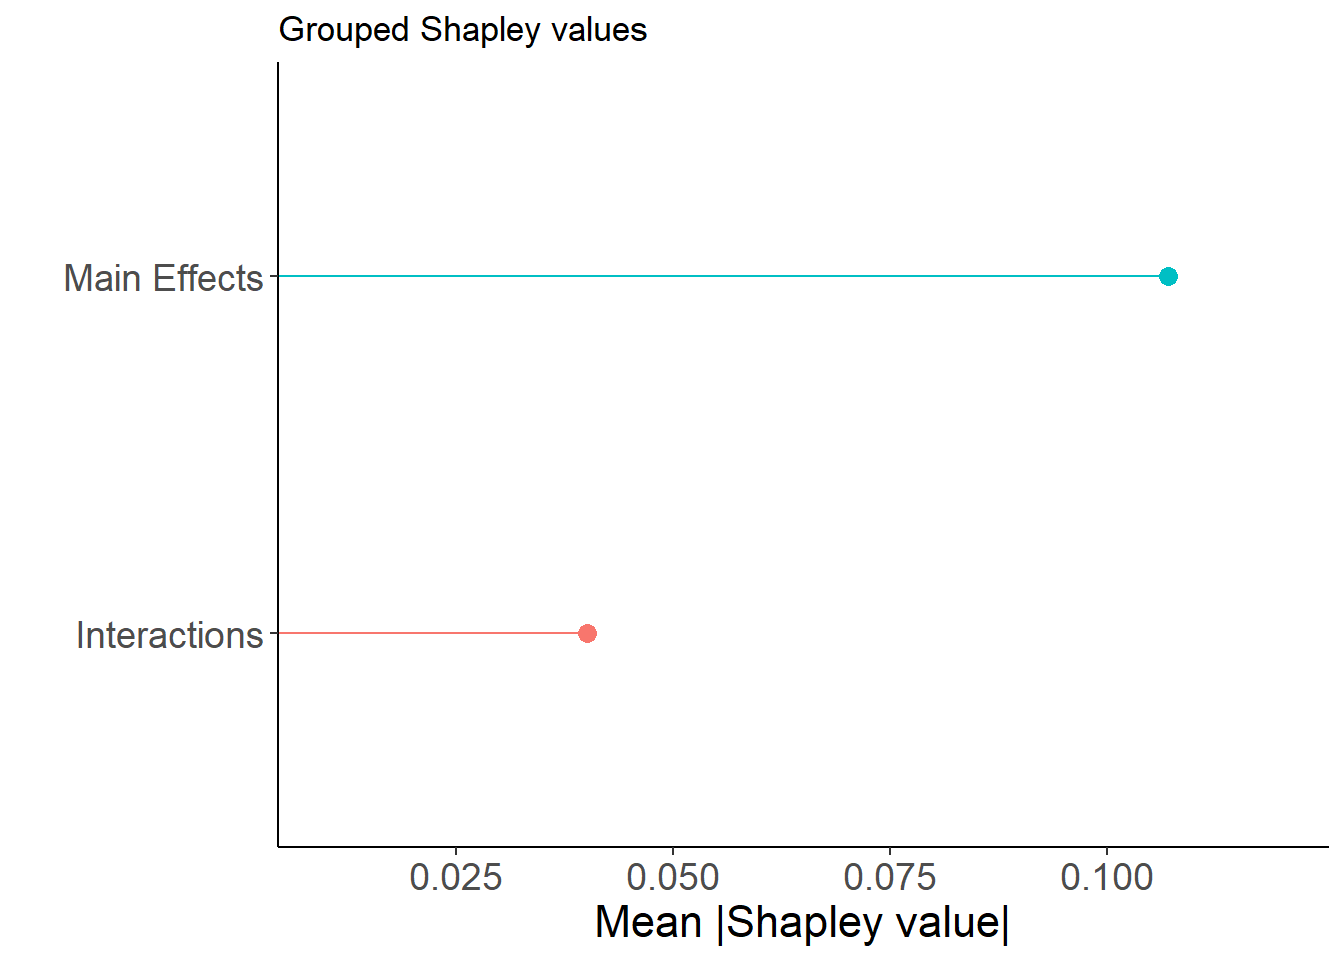

In [ ]:

fig_shap_grouped <- global_grouped |> 
  ggplot(mapping = aes(x = tx_int, y = group_mean_contribution, color = tx_int)) +
  geom_point(size = 3) +
  geom_segment(aes(x = tx_int, y = group_mean_contribution, xend = tx_int),
               yend = 0) +
  labs(
    x = "",
    y = "Mean |Shapley value|",
    color = "Feature Type",
    title = "Grouped Shapley values"
  ) +
  scale_y_continuous(limits = c(0.01, 0.12), breaks = c(0.025, 0.050, 0.075, 0.1)) +
  coord_flip() +
  theme(legend.position = "none",
        axis.text = element_text(size = rel(1.25)),
        axis.title = element_text(size = rel(1.5)))

fig_shap_grouped
